In [2]:
from addit.ncf import conti
import jax.numpy as jnp
import numpy as np

In [ ]:
def inc1D(x,xv):
    """integrated neighbouring contribution array on a line.
    
    Args:
        x: x values (N)
        xv: x grid  (Ng)
            
    Returns:
        integrated neighbouring contribution for i
        
    """
    indarr=jnp.arange(len(xv))
    vcl=vmap(conti,(0,None,None),0)
    return jnp.sum(vcl(indarr,x,xv),axis=1)

In [51]:
from jax.lax import scan
from jax import jit,vmap

@jit
def inc2D(x,y,xv,yv):
    """integrated 2D neighbouring contribution (memory reduced sum).
    
    Args:
        x: x values
        y: x values
        xv: x grid
        yv: x grid
            
    Returns:
        neighbouring contribution 
        
    Note:
        This function computes \sum_n fx_n \otimes fy_n, 
        where fx_n and fy_n are the n-th NCFs for 1D. 
        A direct sum uses huge RAM. 
        In this function, we use jax.lax.scan to compute the sum
        
    Example:
        >>>N=10000
        >>> xv=jnp.linspace(0,1,11) #grid
        >>> yv=jnp.linspace(0,1,11) #grid
        >>> x=np.random.rand(N)
        >>> y=np.random.rand(N)
        >>> val=inc2D(x,y,xv,yv)
        The direct sum is computed as
        >>> valdirect=jnp.sum(nc2D(x,y,xv,yv),axis=2)
        >>> jnp.mean(jnp.sqrt((val/valdirect-1.0)**2))
        >>> DeviceArray(2.0836995e-07, dtype=float32)
        
    """
    Ngx=len(xv)
    Ngy=len(yv)
    indarrx=jnp.arange(Ngx)
    indarry=jnp.arange(Ngy)
    vcl=vmap(conti,(0,None,None),0)
    fx=vcl(indarrx,x,xv) # Ngx x N  memory
    fy=vcl(indarry,y,yv) # Ngy x N memory
    #jnp.sum(fx[:,None]*fy[None,:],axis=2) Ngx x Ngy x N -> huge memory 
    
    fxy=jnp.array([fx,fy]).T
    def fsum(x,arr):
        null=0.0
        fx=arr[:,0]
        fy=arr[:,1]
        val=x+fx[:,None]*fy[None,:]
        return val, null
    
    init0=jnp.zeros((Ngx,Ngy))
    val,null=scan(fsum,init0,fxy)
    return val
    

In [8]:
N=10000
xv=jnp.linspace(0,1,11) #grid
yv=jnp.linspace(0,1,11) #grid
x=np.random.rand(N)
y=np.random.rand(N)

In [52]:
val=inc2D(x,y,xv,yv)
valdirect=jnp.sum(nc2D(x,y,xv,yv),axis=2) # direct sum (lots memory)

In [56]:
jnp.mean(jnp.sqrt((val/valdirect-1.0)**2))

DeviceArray(2.0836995e-07, dtype=float32)

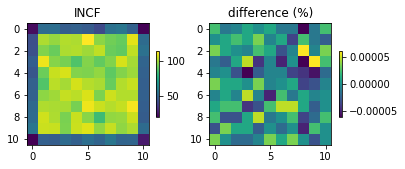

In [54]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_subplot(121)
a=plt.imshow(val)
plt.colorbar(a,shrink=0.3)
plt.title("INCF")
ax=fig.add_subplot(122)
a=plt.imshow((val/valdirect-1.0)*100)
plt.colorbar(a,shrink=0.3)
plt.title("difference (%)")
plt.show()

In [60]:
@jit
def inc3D(x,y,z,xv,yv,zv):
    """integrated neighbouring contribution for 3D (memory reduced sum).
    
    Args:
        x: x values
        y: y values
        z: z values
        xv: x grid
        yv: y grid
        zv: z grid            
        
    Returns:
        integrated neighbouring contribution 
        
    Note:
        This function computes \sum_n fx_n \otimes fy_n \otimes fz_n, 
        where fx_n, fy_n, and fz_n are the n-th NCFs for 1D. 
        A direct sum uses huge RAM. 
        In this function, we use jax.lax.scan to compute the sum
        
    Example:
        >>>N=10000
        >>> xv=jnp.linspace(0,1,11) #grid
        >>> yv=jnp.linspace(0,1,11) #grid
        >>> zv=jnp.linspace(0,1,11) #grid
        >>> x=np.random.rand(N)
        >>> y=np.random.rand(N)
        >>> z=np.random.rand(N)
        >>> val=inc3D(x,y,z,xv,yv,zv)
        The direct sum is computed as
        >>> valdirect=jnp.sum(nc3D(x,y,z,xv,yv,zv),axis=3) # direct sum (lots memory)
        >>> jnp.mean(jnp.sqrt((val/valdirect-1.0)**2))
        >>> DeviceArray(9.686315e-08, dtype=float32)
        
    """
    Ngx=len(xv)
    Ngy=len(yv)
    Ngz=len(zv)
    indarrx=jnp.arange(Ngx)
    indarry=jnp.arange(Ngy)
    indarrz=jnp.arange(Ngz)
    
    vcl=vmap(conti,(0,None,None),0)
    fx=vcl(indarrx,x,xv) # Ngx x N  memory
    fy=vcl(indarry,y,yv) # Ngy x N memory
    fz=vcl(indarrz,z,zv) # Ngz x N memory
    fxyz=jnp.array([fx,fy,fz]).T
    
    def fsum(x,arr):
        null=0.0
        fx=arr[:,0]
        fy=arr[:,1]
        fz=arr[:,2]
        val=x+fx[:,None,None]*fy[None,:,None]*fz[None,None,:]
        return val, null
    
    init0=jnp.zeros((Ngx,Ngy,Ngz))
    val,null=scan(fsum,init0,fxyz)
    return val
    

In [58]:
N=10000
xv=jnp.linspace(0,1,11) #grid
yv=jnp.linspace(0,1,11) #grid
zv=jnp.linspace(0,1,11) #grid
x=np.random.rand(N)
y=np.random.rand(N)
z=np.random.rand(N)

In [62]:
val=inc3D(x,y,z,xv,yv,zv)
valdirect=jnp.sum(nc3D(x,y,z,xv,yv,zv),axis=3) # direct sum (lots memory)

In [63]:
jnp.mean(jnp.sqrt((val/valdirect-1.0)**2))

DeviceArray(9.686315e-08, dtype=float32)